# Portfolio Performance

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils as u
import matplotlib.ticker as mtick

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# Time of Analysis
start = '2022-11-07'
end = '2022-12-13'

benchmark = 'AOK'

In [83]:
# Use helper functions to get data. We require a new bloomberg file to be manually ingested as well as EOD keys to get updated FX prices
df = u.get_updated_data()
df = pd.merge(df, u.get_bloomberg_data(False), how='left', left_index=True, right_index=True)
df = u.add_fx(df)
df.sort_index(ascending=True, inplace=True)
df['rf'] = df.apply(lambda x: u.convert_treasury_price(str(x['rf'])),  axis=1)

df = u.get_usd_prices(df)

In [58]:
# df_b = u.get_bloomberg_data(True)

In [59]:
# Based on the weights, calculate the initial amount of shares we bought (allocation)

weights = {
    'ch': 0.13324,
    'DBC.US': 0.18868,
    'it': 0.1084,
    'SHEL': 0.11132,
    'CSSMI.SW': 0.247,
    'WMT': 0.21136
}

alloc = pd.merge(pd.DataFrame(weights.values(), weights.keys()) * 50_000_000 , pd.DataFrame(df.loc['2022-11-07']), left_index=True, right_index=True, how='inner')
alloc.columns = ['amount', 'price']
alloc['shares'] = (alloc.amount / alloc.price).astype('int')
allocation = alloc.shares.to_dict()
allocation['rf'] = int(50_000_000 / df.loc['2022-11-07'].rf)

In [60]:
(alloc.shares * alloc.price).sum() # should sum to around 50m, the risky portfolio

49999764.68520979

In [84]:
allocation = {'ch': 70246,
 'DBC.US': 358026,
 'it': 57499,
 'SHEL': 98819,
 'CSSMI.SW': 109794,
 'WMT': 74187,
 'rf': 427227
}

In [85]:
p_ret = u.create_portfolio_return_usd(df, allocation)
complete_return = p_ret.copy()
ret_weekly = p_ret['2017-12-03':].resample('1w').last()

In [154]:
p_ret.loc['2017-11-07':].ffill().pct_change().to_csv('port_attr_analysis.csv')

In [46]:
((1+p_ret.Portfolio.pct_change()).cumprod()).dropna().to_csv('port_return_full.csv')

In [37]:
p_ret[['Portfolio']].dropna().to_csv('port_return_full.csv')

In [64]:
p_ret.Portfolio.pct_change().mean() / p_ret.Portfolio.pct_change().std()

0.05691765887933011

In [9]:
# c_ret = u.create_portfolio_returns(df, alloc.shares.to_dict())
# c_ret = pd.merge(c_ret, df.pct_change(), how='left', left_index=True, right_index=True)

In [125]:
c_ret = p_ret.pct_change()

In [152]:
(1 + c_ret.loc['2022-12-02':].Portfolio).cumprod() - 1

date
2022-12-02   -0.001290
2022-12-05   -0.007094
2022-12-06   -0.011525
2022-12-07   -0.011706
2022-12-08   -0.012161
2022-12-09   -0.015331
2022-12-12   -0.012488
2022-12-13   -0.006665
Name: Portfolio, dtype: float64

c:\Users\gobel\anaconda3\lib\site-packages\pypfopt\risk_models.py:264: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


0.14064979124864374 0.2670023606481464 0.12635256939950268
0.11775222857629511 0.0009395433347205027 0.00047227258640187127


{'start': Timestamp('2022-11-07 00:00:00'),
 'end': Timestamp('2022-12-13 00:00:00'),
 'Total Return Pct': 2.4621,
 'Total Return $': 2462070.4005,
 'Daily avg. Return': 0.0947,
 'Daily Expected Return': 0.094,
 'Daily standard deviation': 0.4772,
 'Daily Expected std': 0.0055,
 'Daily Sharpe (Ex-Post)': 0.159,
 'Daily Sharpe (Ex-Ante)': 0.1605,
 'Period Sharpe (Ex-Post)': -0.1546,
 'Period Sharpe (Ex-Ante)': -0.1543,
 'Period Sharpe': 0.8186,
 'Period Sharpe Ann': 2.9077,
 'Daily Sortino': 0.3472,
 'Period Sortino': 1.7705,
 'Daily Treynor (AOK)': 0.1081,
 'Information Ratio (AOK)': 2.2656,
 'Tracking Error (AOK)': 0.0621,
 'Max. Drawdown': 0.7845}

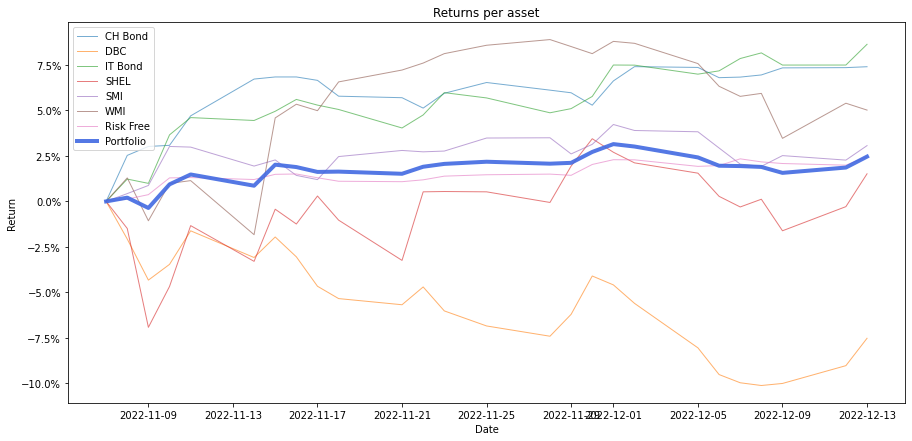

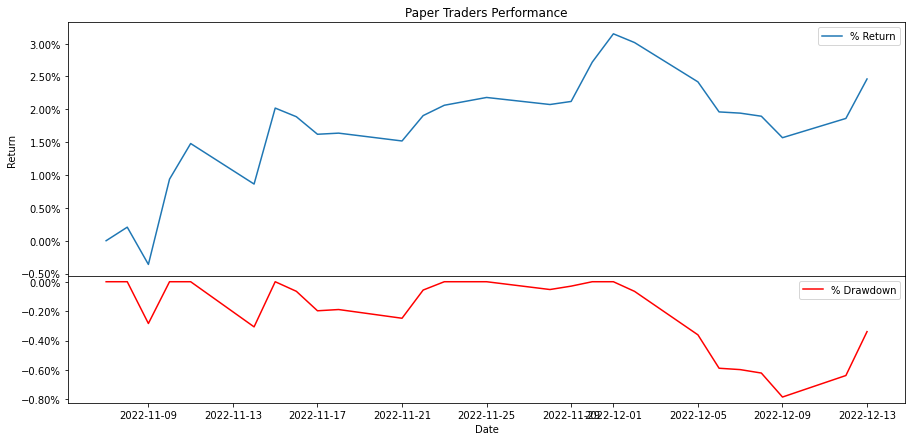

In [142]:
u.portfolio_return(start, end, c_ret)

## Weekly

In [35]:
weekly_pct = ret_weekly.pct_change()

In [36]:
weekly_pct.mean()*52

Portfolio    0.047445
ch           0.007168
DBC.US       0.116165
it           0.007904
SHEL         0.093765
CSSMI.SW     0.076439
WMT          0.135841
rf           0.036923
dtype: float64

In [37]:
(weekly_pct.mean()*52-0.045) / weekly_pct.pct_change().std()*np.sqrt(52)

Portfolio    0.000351
ch          -0.039370
DBC.US            NaN
it          -0.015387
SHEL              NaN
CSSMI.SW     0.004440
WMT               NaN
rf          -0.010156
dtype: float64

<AxesSubplot: >

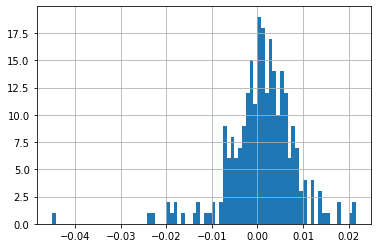

In [38]:
weekly_pct.Portfolio.hist(bins=80)

In [39]:
y = ret_weekly.resample('1y').last()
(y.pct_change().mean()*52-0.045) / y.pct_change().std()*np.sqrt(52)

Portfolio    277.819487
ch             3.279628
DBC.US       184.151240
it            25.704135
SHEL          68.026442
CSSMI.SW     151.682759
WMT          286.818873
rf           210.116769
dtype: float64

In [140]:
u.portfolio_return('2017-12-17', '2022-12-04', weekly_pct)

NameError: name 'weekly_pct' is not defined

<AxesSubplot: xlabel='date'>

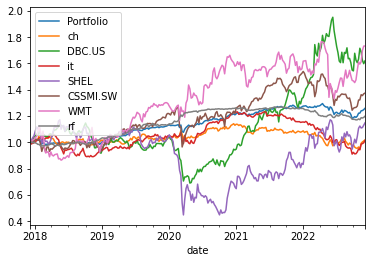

In [41]:
(1+weekly_pct).cumprod().plot()

## Change in Weights

In [88]:
p_ret_noport = p_ret.loc[:, p_ret.columns != 'Portfolio']

In [89]:
c_weights = p_ret_noport.div(p_ret_noport.sum(axis=1), axis=0)
c_weights.columns = ['CH Bond', 'DBC', 'IT Bond', 'SHEL', 'SMI', 'WMI', 'Risk Free']

In [93]:
c_weights_b = c_weights.loc[end] / c_weights.loc[start] - 1

In [97]:
c_weights.iloc[-1]

CH Bond      0.069386
DBC          0.085903
IT Bond      0.058149
SHEL         0.055349
SMI          0.124717
WMI          0.106807
Risk Free    0.499688
Name: 2022-12-13 00:00:00, dtype: float64

In [94]:
c_weights_b

CH Bond      0.031678
DBC         -0.089308
IT Bond      0.055241
SHEL        -0.005438
SMI          0.009993
WMI          0.014622
Risk Free    0.001562
dtype: float64

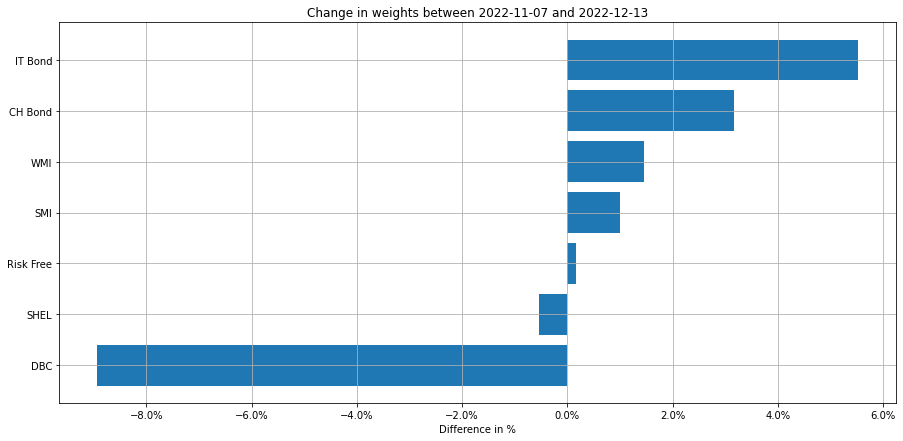

In [95]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')
plt.barh(c_weights_b.sort_values().index, c_weights_b.sort_values())
ax.set_xlabel('Difference in %')
ax.set_title(f"Change in weights between {start} and {end}")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid()

## Risk Metrics

In [109]:
c_ret = complete_return.pct_change()['2017-12-04':]

In [110]:
u.check_normality(c_ret.Portfolio)

The portfolio returns are likely not normal.


Text(0, 0.5, 'Observation Frequency')

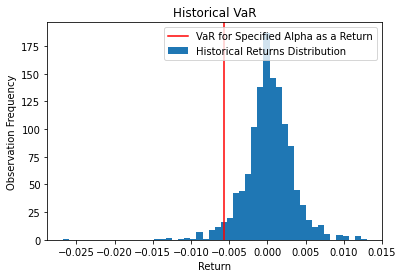

In [111]:
portfolio_VaR = u.value_at_risk(c_ret.Portfolio)
portfolio_VaR_return = portfolio_VaR / 100_000_000

plt.hist(c_ret.Portfolio, bins=50)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

-1300145.9021524761

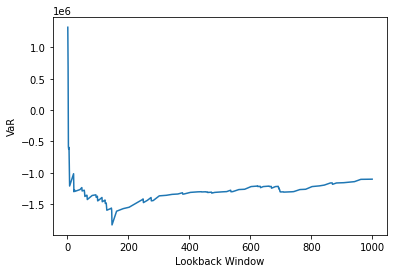

In [112]:
# Test the Value at risk for multiple lookbacks to see if they converge on a value

N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = u.value_at_risk(c_ret.Portfolio, lookback_days=i) * np.sqrt(5)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR')
pd.DataFrame(VaRs)[0].median()

Text(0, 0.5, 'Observation Frequency')

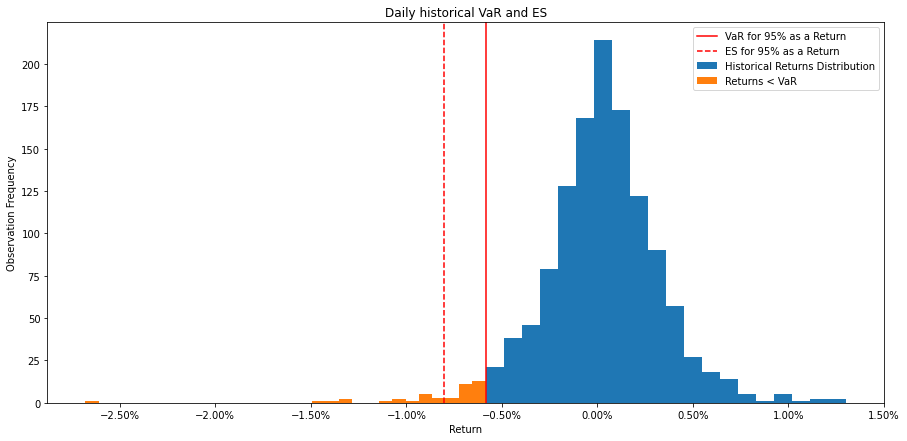

In [113]:
value_invested = 100000000
portfolio_VaR = u.value_at_risk(c_ret.Portfolio, alpha=0.95, lookback_days=500)
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = u.es(c_ret.Portfolio, alpha=0.95, lookback_days=500) 
portfolio_CVaR_return = portfolio_CVaR / value_invested

fig, ax = plt.subplots(figsize=(15,7), facecolor='white')
plt.hist(c_ret.Portfolio[c_ret.Portfolio > portfolio_VaR_return], bins=20)
plt.hist(c_ret.Portfolio[c_ret.Portfolio < portfolio_VaR_return], bins=30)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed')
plt.legend(['VaR for 95% as a Return',
            'ES for 95% as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Daily historical VaR and ES')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

c:\Users\gobel\code\research_env\USI\financial_modelling\portfolio_opt\utils.py:327: RuntimeWarning: Mean of empty slice


-1827503.5865547226

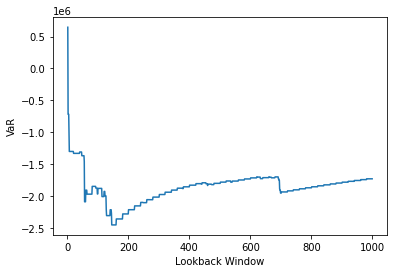

In [114]:
# Get the Expected Shortfall

N = 1000
expected_shortfall = np.zeros((N, 1))
for i in range(N):
    expected_shortfall[i] = u.es(c_ret.Portfolio, lookback_days=i) * np.sqrt(5)

plt.plot(expected_shortfall)
plt.xlabel('Lookback Window')
plt.ylabel('VaR')

pd.DataFrame(expected_shortfall).median()[0]

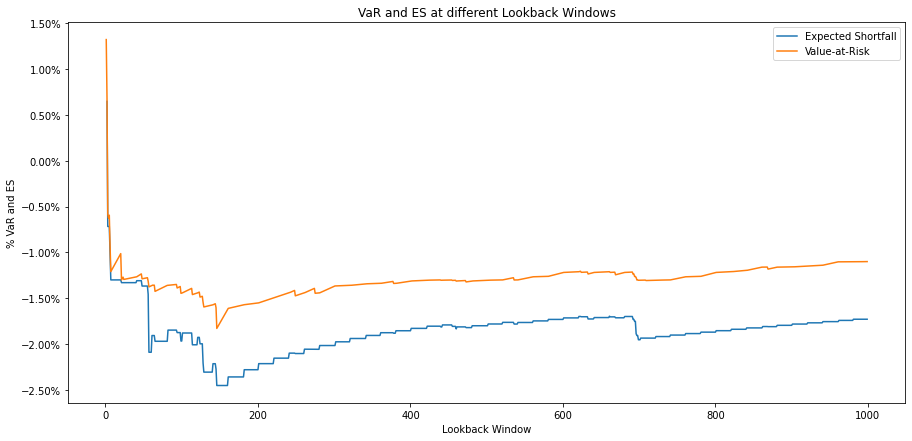

In [115]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')
plt.plot(expected_shortfall / 100_000_000, label='Expected Shortfall')
plt.plot(VaRs / 100_000_000, label='Value-at-Risk')
plt.title('VaR and ES at different Lookback Windows')
plt.xlabel('Lookback Window')
plt.ylabel('% VaR and ES')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

## Sensitivity

In [116]:
from eod import EodHistoricalData

API_KEY = '5e6b41389b9ab8.33631133' 
client = EodHistoricalData(API_KEY)

In [117]:
"""
AOM = iShares Core Moderate Allocation ETF
AOK = iShares Core Conservative Allocation ETF
VGK = Vanguard FTSE Europe ETF
EZU = iShares MSCI Eurozone ETF
VXX = iPath Series B S&P 500 VIX Short-Term Futures ETN
USO = United States Oil Fund LP
BND = Vanguard Total Bond Market ETF
SHY = iShares 1-3 Year Treasury Bond ETF
TLT = iShares 20+ Year Treasury Bond ETF
DBC = Invesco DB Commodity Index Tracking Fund
SPY = SPDR S&P 500 ETF Trust
"""

'\nAOM = iShares Core Moderate Allocation ETF\nAOK = iShares Core Conservative Allocation ETF\nVGK = Vanguard FTSE Europe ETF\nEZU = iShares MSCI Eurozone ETF\nVXX = iPath Series B S&P 500 VIX Short-Term Futures ETN\nUSO = United States Oil Fund LP\nBND = Vanguard Total Bond Market ETF\nSHY = iShares 1-3 Year Treasury Bond ETF\nTLT = iShares 20+ Year Treasury Bond ETF\nDBC = Invesco DB Commodity Index Tracking Fund\nSPY = SPDR S&P 500 ETF Trust\n'

In [5]:
spy = pd.DataFrame(client.get_prices_eod('SPY', period='d', order='a', from_='2010-01-01'))
spy.set_index(pd.to_datetime(spy.date), inplace=True)

In [14]:
other = pd.DataFrame(client.get_prices_eod('XGSD.SW', period='d', order='a', from_='2010-01-01'))
other.set_index(pd.to_datetime(other.date), inplace=True)

In [22]:
tmp = other[['adjusted_close']].pct_change()
tmp['spy'] = spy.adjusted_close.pct_change()

In [25]:
print(tmp.cov() / tmp.adjusted_close.var())
print(tmp.cov() / tmp.spy.var())

                adjusted_close       spy
adjusted_close         1.00000  0.333150
spy                    0.33315  0.965978
                adjusted_close       spy
adjusted_close        1.035221  0.344883
spy                   0.344883  1.000000


In [143]:
indices = ['AOM', 'AOK', 'VGK', 'EZU', 'VXX', 'USO', 'BND', 'SHY', 'TLT', 'DBC', 'SPY', 'EUR.FOREX', 'CHF.FOREX', 'BAMPX']

for i in indices:
    spy = pd.DataFrame(client.get_prices_eod(i, period='d', order='a', from_='2010-01-01'))
    spy.set_index(pd.to_datetime(spy.date), inplace=True)
    c_ret[i] = spy.close.pct_change()

In [144]:
cov = c_ret['2017-12':].cov()

for i in indices:
    var = c_ret['2017-12':][i].var()
    print(i, cov.loc['Portfolio', i]/var)

AOM 0.3726453229861848
AOK 0.4462879408643138
VGK 0.14705528108703197
EZU 0.12981601427348494
VXX -0.0073758378932903814
USO 0.0007546208279711296
BND 0.3492240149416152
SHY 0.9880130339172818
TLT 0.04453808572982051
DBC 0.1397909633561012
SPY 0.131140098059995
EUR.FOREX -0.07496077128772421
CHF.FOREX -0.06139060654054266
BAMPX 0.2210252323920795


## FX Exposure

In [120]:
currency_exp = {
    'DBC.US': 'USD', 
    'WMT': 'USD', 
    'SHEL': 'USD', 
    'CSSMI.SW': 'CHF', 
    'ch': 'CHF',
    'it': 'EUR',
    'rf': 'USD'
}

In [121]:
fx_weights = pd.DataFrame()

for i in currency_exp.keys():
    if currency_exp[i] in fx_weights.columns:
        fx_weights[currency_exp[i]] += p_ret[i] 
    else:
        fx_weights[currency_exp[i]] = p_ret[i]

In [123]:
fx_weights.div(fx_weights.sum(axis=1), axis=0).loc[start:]

,USD,CHF,EUR
date,,,
2022-11-07,0.754156,0.190738,0.055105
2022-11-08,0.752606,0.191990,0.055404
2022-11-09,0.750445,0.193965,0.055589
2022-11-10,0.749531,0.194145,0.056324
2022-11-11,0.749343,0.194121,0.056535
2022-11-14,0.747851,0.195354,0.056795
2022-11-15,0.749953,0.193624,0.056423
2022-11-16,0.750314,0.192840,0.056847
2022-11-17,0.750231,0.192942,0.056827


## FamaFrench